In [2]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [23]:
training_data = np.load('data.npy', allow_pickle=True)
training_labels = np.load('labels.npy', allow_pickle=True)


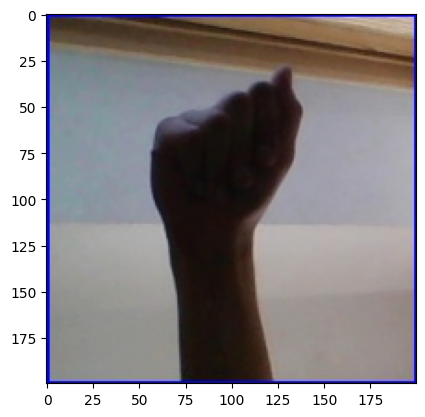

A


In [25]:
data = []
for i in range(len(training_data)):
    data.append([training_data[i], training_labels[i]])

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def transform(self, sample):
        return sample
    
    def plot(self, idx):
        sample = self.data[idx]
        plt.imshow(sample[0])
        plt.show()
        print(sample[1])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), label
    
    
# load the custom dataset
custom_dataset = CustomDataset(data, transform=ToTensor())

# plot the first image
custom_dataset.plot(0)


In [15]:
labels_map = {}
for i, label in enumerate(training_labels):
    if label not in labels_map:
        labels_map[i] = label

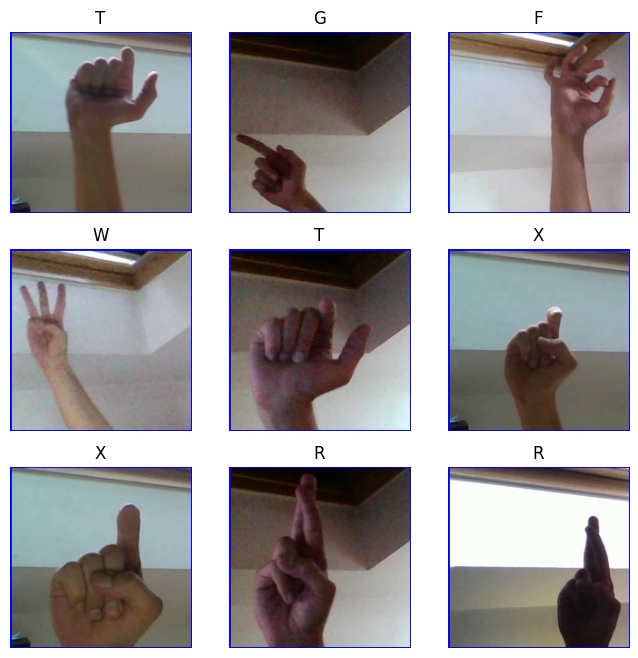

In [16]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [44]:
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, test_size])

In [45]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 200, 200])
Labels batch shape: 64


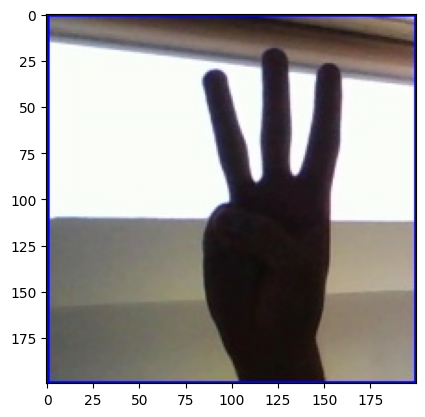

Label: W


In [42]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[0].squeeze()
img = img.permute((1, 2, 0))
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")